In [24]:
import pandas as pd
import pennylane as qml
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
import sklearn as sk
import pathlib as Path
import polars as pl
np.random.seed(42)

In [45]:
# Read the data from a CSV file from data/EstData.csv
data = pl.read_csv("../../data/EstData.csv")
data

ID,BW,COMED,DOSE,TIME,DV,EVID,MDV,AMT,CMT,DVID
i64,i64,i64,i64,i64,f64,i64,i64,i64,i64,i64
1,58,0,0,0,18.6174,0,0,0,3,2
1,58,0,0,1,13.7783,0,0,0,3,2
1,58,0,0,2,16.5747,0,0,0,3,2
1,58,0,0,4,16.8486,0,0,0,3,2
1,58,0,0,8,18.6459,0,0,0,3,2
…,…,…,…,…,…,…,…,…,…,…
48,61,0,10,840,3.3777,0,0,0,3,2
48,61,0,10,1008,1.54816,0,0,0,2,1
48,61,0,10,1008,3.43845,0,0,0,3,2



### Overview of the data ###

Pharmacokinetics (PK): describes how the body interacts with the drug in terms of its absorption, distribution, metabolism, and elimination. It models how drug concentration changes over time in the body
Pharmacodynamics (PD): describes how the drug interacts with the body, linking drug concentration to its biological effect. PD models relate the concentration of a drug to the intensity and duration of its effects.

PK/PD: A combined PK/PD model integrates both aspects; it predicts the time course of drug effects based on the dosing regimen.

1.) ID: Subject Identifier

2.) BW: Body Weight (in kg)

3.) COMED:  Concomitant medication indicator for the subject (0: No, 1: Yes)

4.) DOSE: Dose level in mg. This column represents the amount of drug administered to the subject. It is typically measured in units like milligrams (mg) or micrograms (μg). The dose is a critical factor in determining the drug’s pharmacokinetic and pharmacodynamic properties.

5.) TIME: Time in hours. Indicates the time elapsed since the start of the first drug administration. 
                         Time is typically measured in hours or minutes and is essential for plotting concentration-time profiles.

6.) DV (Dependent Variable): Compound concentration (mg/L) for DVID=1. Biomarker level (ng/mL) for DVID=2. 
                    This column usually represents observed data, such as drug concentration in plasma or another biological matrix. 
                    It can also refer to the measurement of a biomarker or response variable affected by the drug, such as blood pressure or heart rate.

7.) EVID (Event ID): This is an event identifier used in NONMEM (a common software in pharmacometrics). It signifies the type of event occurring:
        EVID = 0 for observation events (e.g., a concentration measurement),
        EVID = 1 for dosing events
        
8.) MDV (Missing Dependent Variable): This value indicates whether the dependent variable (DV) is missing. An MDV of 1 means the DV value is missing, while 0 means it is present

9.) AMT (Amount): Stands for the actual dose amount administered, especially applicable during infusion dosing. AMT will be zero for observation records.

10.) CMT (Compartment): This denotes the compartment where the event (e.g., dosing or sampling) occurs. In PK models, different compartments (like central and peripheral) help to describe drug kinetics.

11.) DVID (Dependent Variable ID): This identifier helps distinguish between different types of DVs in the dataset. For example, you might have multiple measurement types such as concentrations and biomarkers.



In [26]:
def interpolate_nan_intervals_polars(df, column):
    """
    Replace intervals of null values in a Polars DataFrame column with linearly interpolated values
    from the first and last non-null values surrounding the interval.
    
    Parameters:
    -----------
    df : pl.DataFrame
        Input DataFrame
    column : str
        Name of the column to interpolate
        
    Returns:
    --------
    pl.DataFrame
        DataFrame with null intervals in the column replaced by linearly interpolated values
        
    Raises:
    -------
    ValueError
        If the first or last element of the column is null
    """
    # Check if first or last element is null
    if df[column].is_null()[0] or df[column].is_null()[-1]:
        raise ValueError("The first or last element of the column is null, cannot interpolate.")
    
    # Interpolate null values
    return df.with_columns(pl.col(column).interpolate())

In [47]:
data

ID,BW,COMED,DOSE,TIME,DV,EVID,MDV,AMT,CMT,DVID
i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
1,58.0,0.0,0.0,0.0,18.6174,0.0,0.0,0.0,3.0,2.0
1,58.0,0.0,0.0,1.0,13.7783,0.0,0.0,0.0,3.0,2.0
1,58.0,0.0,0.0,2.0,16.5747,0.0,0.0,0.0,3.0,2.0
1,58.0,0.0,0.0,4.0,16.8486,0.0,0.0,0.0,3.0,2.0
1,58.0,0.0,0.0,8.0,18.6459,0.0,0.0,0.0,3.0,2.0
…,…,…,…,…,…,…,…,…,…,…
48,61.0,0.0,10.0,840.0,3.3777,0.0,0.0,0.0,3.0,2.0
48,61.0,0.0,10.0,1008.0,1.54816,0.0,0.0,0.0,2.0,1.0
48,61.0,0.0,10.0,1008.0,3.43845,0.0,0.0,0.0,3.0,2.0


In [46]:
# Find any nulls and replace with Polars interpolate function
# Not doing ID's since there are no Nans there
data = interpolate_nan_intervals_polars(data, "BW")
data = interpolate_nan_intervals_polars(data, "COMED")
data = interpolate_nan_intervals_polars(data, "DOSE")
data = interpolate_nan_intervals_polars(data, "TIME")
data = interpolate_nan_intervals_polars(data, "DV")

data = interpolate_nan_intervals_polars(data, "EVID")
data = interpolate_nan_intervals_polars(data, "MDV")
data = interpolate_nan_intervals_polars(data, "AMT")
data = interpolate_nan_intervals_polars(data, "CMT")
data = interpolate_nan_intervals_polars(data, "DVID")

data

ID,BW,COMED,DOSE,TIME,DV,EVID,MDV,AMT,CMT,DVID
i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
1,58.0,0.0,0.0,0.0,18.6174,0.0,0.0,0.0,3.0,2.0
1,58.0,0.0,0.0,1.0,13.7783,0.0,0.0,0.0,3.0,2.0
1,58.0,0.0,0.0,2.0,16.5747,0.0,0.0,0.0,3.0,2.0
1,58.0,0.0,0.0,4.0,16.8486,0.0,0.0,0.0,3.0,2.0
1,58.0,0.0,0.0,8.0,18.6459,0.0,0.0,0.0,3.0,2.0
…,…,…,…,…,…,…,…,…,…,…
48,61.0,0.0,10.0,840.0,3.3777,0.0,0.0,0.0,3.0,2.0
48,61.0,0.0,10.0,1008.0,1.54816,0.0,0.0,0.0,2.0,1.0
48,61.0,0.0,10.0,1008.0,3.43845,0.0,0.0,0.0,3.0,2.0


In [29]:
# Since data has now been preprocessed, Let's make PK Model

def pk_model(data):
    # Define the model structure
    model = {
        "BW": data["BW"].mean(),
        "COMED": data["COMED"].mean(),
        "DOSE": data["DOSE"].mean(),
        "TIME": data["TIME"].mean(),
        "DV": data["DV"].mean(),
        "EVID": data["EVID"].mean(),
        "MDV": data["MDV"].mean(),
        "AMT": data["AMT"].mean(),
        "CMT": data["CMT"].mean(),
        "DVID": data["DVID"].mean()
    }
    return model

print(pk_model(data))

{'BW': 73.08156028368795, 'COMED': 0.48404255319148937, 'DOSE': 4.170212765957447, 'TIME': 331.531914893617, 'DV': 3.4926242093404265, 'EVID': 0.2680851063829787, 'MDV': 0.2680851063829787, 'AMT': 1.251063829787234, 'CMT': 2.157446808510638, 'DVID': 1.1574468085106382}


In [35]:
'''Typical Dynamic PK Model

--> State Variables (D(t) , A(t))
--> Input Variables (D)
--> Output Variables (C)
--> Parameters (variability)
--> Equations (differential)

PK Model should include at least:
1.) ID
2.) TIME
3.) DV (Dependent Variable: observed Value)
4.) AMT (Bolus amount (0 if none))
5.) MDV (Missing DV (also for dose record))
6.) CMT (compartment # of obs or dose (Larger models))
7.) DOSE (Dose amount)

'''

def pk_model(df):
    """
    Build a pharmacokinetic (PK) model from the given DataFrame.

    Parameters:
    -----------
    df : pl.DataFrame
        Input DataFrame containing the necessary columns for the PK model.

    Returns:
    --------
    pl.DataFrame
        DataFrame with the PK model results.
    """
    # Check if all required columns are present
    required_columns = ['ID', 'TIME', 'DV', 'AMT', 'MDV', 'CMT', 'DOSE']
    for col in required_columns:
        if col not in df.columns:
            raise ValueError(f"Missing required column: {col}")

    # Implement the PK model logic here
    # This is a placeholder for the actual model implementation
    pk_results = df.select([pl.col(col) for col in required_columns])

    return pk_results

pk = pk_model(data)
pk

ID,TIME,DV,AMT,MDV,CMT,DOSE
i64,f64,f64,f64,f64,f64,f64
1,0.0,18.6174,0.0,0.0,3.0,0.0
1,1.0,13.7783,0.0,0.0,3.0,0.0
1,2.0,16.5747,0.0,0.0,3.0,0.0
1,4.0,16.8486,0.0,0.0,3.0,0.0
1,8.0,18.6459,0.0,0.0,3.0,0.0
…,…,…,…,…,…,…
48,840.0,3.3777,0.0,0.0,3.0,10.0
48,1008.0,1.54816,0.0,0.0,2.0,10.0
48,1008.0,3.43845,0.0,0.0,3.0,10.0


Fitted PK parameters for subjects:
ID 13: ka=10.000 h^-1, k=0.001 h^-1, V=3.841 L
ID 14: ka=10.000 h^-1, k=0.001 h^-1, V=5.908 L
ID 15: ka=1.013 h^-1, k=0.043 h^-1, V=0.266 L
ID 16: ka=10.000 h^-1, k=0.001 h^-1, V=5.242 L
ID 17: ka=10.000 h^-1, k=0.001 h^-1, V=3.242 L
ID 18: ka=10.000 h^-1, k=0.001 h^-1, V=3.845 L
ID 19: ka=0.530 h^-1, k=0.049 h^-1, V=0.291 L
ID 20: ka=10.000 h^-1, k=0.001 h^-1, V=4.349 L
ID 21: ka=10.000 h^-1, k=0.001 h^-1, V=5.372 L
ID 22: ka=10.000 h^-1, k=0.001 h^-1, V=4.314 L
ID 23: ka=10.000 h^-1, k=0.001 h^-1, V=4.260 L
ID 24: ka=10.000 h^-1, k=0.001 h^-1, V=3.050 L
ID 25: ka=0.430 h^-1, k=0.055 h^-1, V=0.693 L
ID 26: ka=1.027 h^-1, k=0.045 h^-1, V=0.742 L
ID 27: ka=0.862 h^-1, k=0.046 h^-1, V=0.697 L
ID 28: ka=0.677 h^-1, k=0.049 h^-1, V=0.608 L
ID 29: ka=0.495 h^-1, k=0.054 h^-1, V=0.614 L
ID 30: ka=0.644 h^-1, k=0.051 h^-1, V=0.562 L
ID 31: ka=0.694 h^-1, k=0.048 h^-1, V=0.639 L
ID 32: ka=0.742 h^-1, k=0.055 h^-1, V=0.510 L
ID 33: ka=0.825 h^-1, k=0.046 h^-1,

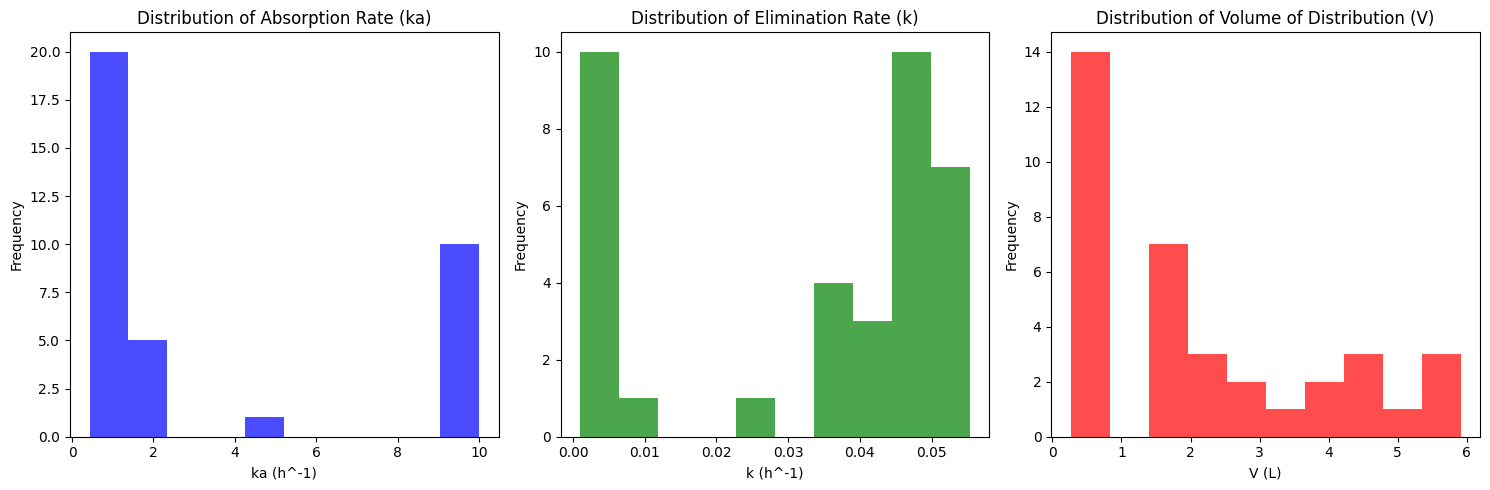


Summary Statistics for PK Parameters:
ka: mean=3.578, std=4.045, CV=113.0%
k: mean=0.032, std=0.021, CV=65.3%
V: mean=2.162, std=1.717, CV=79.4%


In [49]:
# Implement a one-compartment PK model with first-order absorption, handling multiple doses

def fit_pk(subject_data):
    """
    Fit the PK model to a subject's data, accounting for multiple doses.
    """
    obs = subject_data.filter((pl.col('EVID') == 0) & (pl.col('MDV') == 0))
    if len(obs) == 0:
        return None
    t_obs = obs['TIME'].to_numpy()
    c_obs = obs['DV'].to_numpy()
    
    doses = subject_data.filter(pl.col('EVID') == 1).select(['TIME', 'AMT'])
    if len(doses) == 0:
        return None
    
    def model(t, ka, k, V):
        c = np.zeros_like(t)
        for i, t_val in enumerate(t):
            for row in doses.rows():
                t_dose, amt = row
                if t_val >= t_dose and ka != k:
                    c[i] += (amt * ka / (V * (ka - k))) * (np.exp(-k * (t_val - t_dose)) - np.exp(-ka * (t_val - t_dose)))
        return c
    
    # Initial guesses and bounds
    p0 = [1.0, 0.1, 10.0]
    bounds = ([0.01, 0.001, 0.1], [10.0, 1.0, 100.0])  # Reasonable bounds
    
    try:
        popt, pcov = opt.curve_fit(model, t_obs, c_obs, p0=p0, bounds=bounds, maxfev=10000)
        return popt
    except Exception as e:
        print(f"Fitting failed for subject: {e}")
        return None

# Fit the model for each subject
subjects = data['ID'].unique()
params = {}
for id_val in subjects:
    subj_data = data.filter(pl.col('ID') == id_val)
    result = fit_pk(subj_data)
    if result is not None:
        params[id_val] = result

# Display fitted parameters
print("Fitted PK parameters for subjects:")
for id_val, p in params.items():
    print(f"ID {id_val}: ka={p[0]:.3f} h^-1, k={p[1]:.3f} h^-1, V={p[2]:.3f} L")

# Assess inter-subject variability
if params:
    ka_vals = [p[0] for p in params.values()]
    k_vals = [p[1] for p in params.values()]
    V_vals = [p[2] for p in params.values()]
    
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.hist(ka_vals, bins=10, alpha=0.7, color='blue')
    plt.title('Distribution of Absorption Rate (ka)')
    plt.xlabel('ka (h^-1)')
    plt.ylabel('Frequency')
    
    plt.subplot(1, 3, 2)
    plt.hist(k_vals, bins=10, alpha=0.7, color='green')
    plt.title('Distribution of Elimination Rate (k)')
    plt.xlabel('k (h^-1)')
    plt.ylabel('Frequency')
    
    plt.subplot(1, 3, 3)
    plt.hist(V_vals, bins=10, alpha=0.7, color='red')
    plt.title('Distribution of Volume of Distribution (V)')
    plt.xlabel('V (L)')
    plt.ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()
    
    # Summary statistics
    print("\nSummary Statistics for PK Parameters:")
    print(f"ka: mean={np.mean(ka_vals):.3f}, std={np.std(ka_vals):.3f}, CV={np.std(ka_vals)/np.mean(ka_vals)*100:.1f}%")
    print(f"k: mean={np.mean(k_vals):.3f}, std={np.std(k_vals):.3f}, CV={np.std(k_vals)/np.mean(k_vals)*100:.1f}%")
    print(f"V: mean={np.mean(V_vals):.3f}, std={np.std(V_vals):.3f}, CV={np.std(V_vals)/np.mean(V_vals)*100:.1f}%")
else:
    print("No successful fits.")